## Non-stationary time series 

In [3]:
## import all the modules need to be used
import statsmodels 
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import matplotlib.pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
## load exercise data, it is just two white noise seres 
df = pd.read_csv('../data/module3_data_Simulated_Nonstationary.csv')
print(df.head())

     dateid01                   dateid         x         y         z
0  1900-01-01  1900-01-31 23:59:59.999  0.000000  0.000000  0.000000
1  1900-02-01  1900-02-28 23:59:59.999  2.644404 -0.723371  2.538293
2  1900-03-01  1900-03-31 23:59:59.999  3.439934  2.142096  2.227375
3  1900-04-01  1900-04-30 23:59:59.999  3.615788  4.493112  4.767550
4  1900-05-01  1900-05-31 23:59:59.999  4.764565  5.088569  4.051969


### 1. Simulate two non-stationary time series and take a look at their properties 

In [5]:
## first, index the time variable 
df['time'] = pd.to_datetime(df.dateid01)
df.index = df['time']

In [7]:
### generate two non-stationary time series 
mu, sigma = 0,10       ## set mean and sd for the noise
## generate non-stationary series based on:
#mt = 1.5 + mt-1 + emt
#nt = -2 + nt-1 + ent
mt = np.zeros(len(df))
nt = np.zeros(len(df))
for x in range(1,len(df)):
    mt[x] = 1.5+mt[x-1] + np.random.normal(mu,sigma)
    nt[x] = -2+nt[x-1] + np.random.normal(mu,sigma)
df['mt'] = mt
df['nt'] = nt

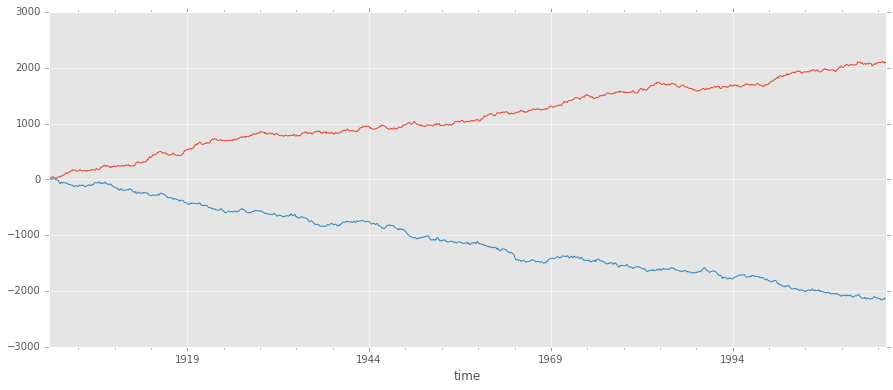

In [8]:
## take a look at the line chart, there is obciously a trend and possibly a random walk 
plt.figure()
df.mt.plot.line()
df.nt.plot.line()

Now, let's take a look the the correlogram, if it is non-stationary, shocks do not die down

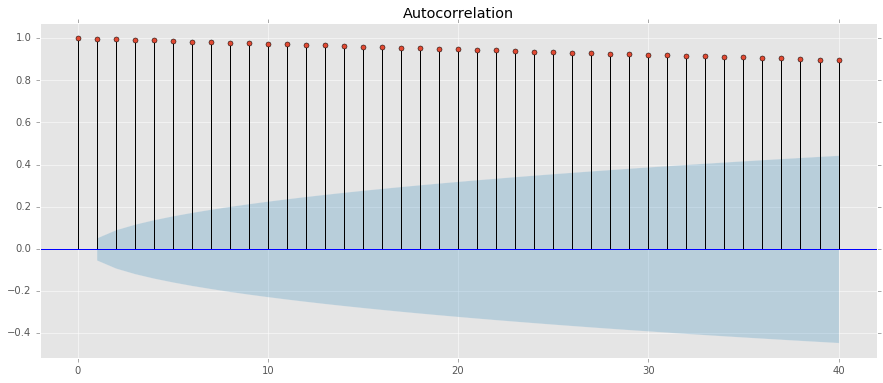

In [9]:
acf_figure = sm.graphics.tsa.plot_acf(df.mt,lags = 40)
#pacf_figure = sm.graphics.tsa.plot_pacf(df.mt,lags = 40)
## this is a common patten we will see in non-stationary time series 

### 2. If we run a regression on two non-stationary time series, we will get sperious corrolation. our coefficient will be significant, but it does not implay any causal realtionship

In [13]:
X = df.nt
X = sm.add_constant(X)
y = df.mt
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

## we can see the coefficient is very significant, but there is basically not realy relation between these 
## two simulated series

                            OLS Regression Results                            
Dep. Variable:                     mt   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 2.924e+04
Date:                Thu, 29 Sep 2016   Prob (F-statistic):               0.00
Time:                        14:06:33   Log-Likelihood:                -8315.1
No. Observations:                1382   AIC:                         1.663e+04
Df Residuals:                    1380   BIC:                         1.664e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        259.1847      4.492     57.697      0.0

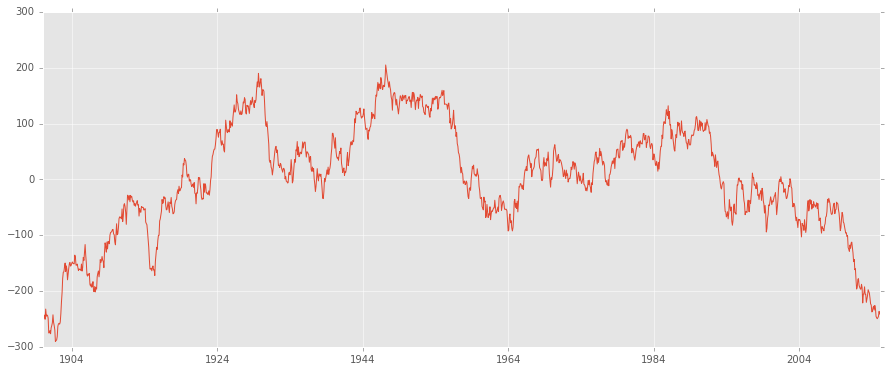

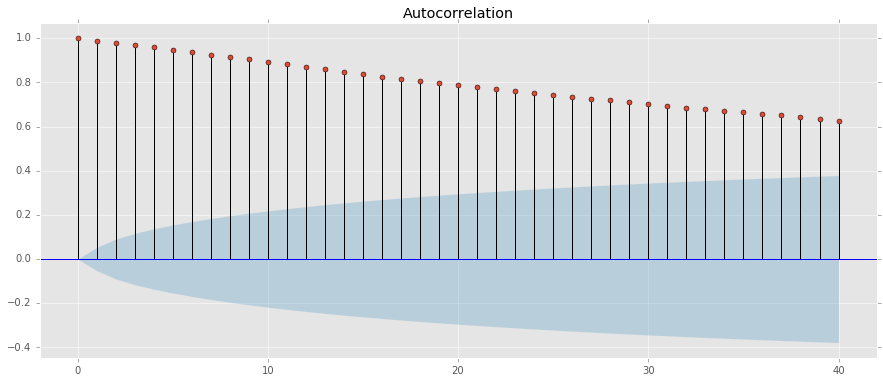

In [16]:
## we can also take a look at the residual, see if it is un corrolated 
resid = results.resid
plt.plot(resid)
acf_figure = sm.graphics.tsa.plot_acf(resid,lags = 40)
## the resids are obvious corrolated, which mean the model is biased 

### 3. How do we test for Nonstationary - real world data

Ok, now lets look at some real world data to see how we can use different tests to determine if it is stationary or Nonstationary 

In [21]:
## load exercise data, it is the PE ratio for 5 different countries
## traditionally, pe ratio tends to be stationary 
df_pe = pd.read_csv('../data/module3_data_PE_Ratios.csv')
df_pe['time'] = pd.to_datetime(df_pe.dateid01)
df_pe.index = df_pe['time']
print df_pe.dtypes

dateid01            object
dateid              object
date                object
pe_aus             float64
pe_ind             float64
pe_ndo             float64
pe_saf             float64
pe_usa             float64
time        datetime64[ns]
dtype: object


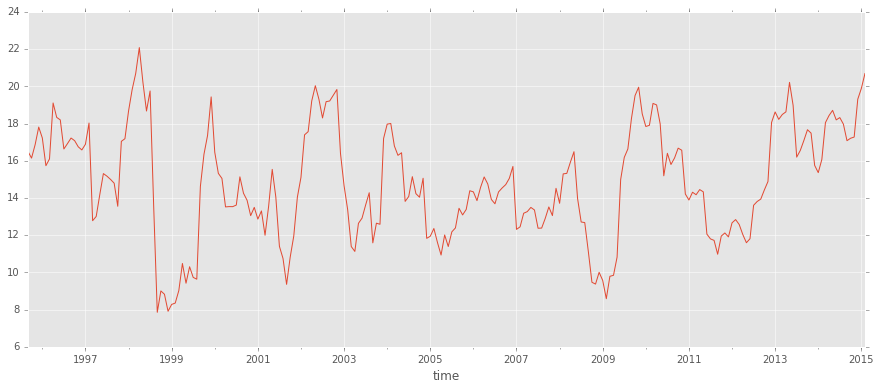

In [34]:
## ok lats take a look at south africa 
saf = df_pe.pe_saf[df_pe.pe_saf.notnull()]         # let look at only non-missing value
#saf = df_pe.pe_saf.loc['1995-09-01':]            # we can also filter by date

saf.plot.line()                                   # take a look at the line chart 

## from the line chart, it seems to be stationary, but it could be a random walk as well, we need to test it

##### Augmented; PP test ; KPSS teaet

From the chart, we can see that the mean won't be around zero, so we probably want to include constant in the test. we may or may not want to trend in the test. We can look at the regression results to determine if we want constat, trend in the test. 

#### correct specification has huge impact on the resting result, so we do want to be very carefully about this 

#### ADF test

In [105]:
## There are three commonly used tests for unit roots. they are essentiall testing d_y = b*yt-1 + error
## see if b = 1. if b = 1, then we have a unit root, the time series is nonstationary. The equation can
## have constant and trend in it as well. 

## ADF test 

## or we can also use arch model ADF test
from arch.unitroot import ADF

adf = ADF(saf,trend='c',method='AIC')
print adf
print adf.regression.summary()

#### following is how to use statsmodels 
## statsmodels.tsa.stattools.adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
# results = tsa.adfuller(saf,regression='c', autolag='AIC',regresults=True)
# adf_dict =pd.DataFrame({'t-Statistic':[results[0]],'P-value':[results[1]]})
# confidence = pd.DataFrame([results[2]])
# ols_res = results[-1].resols
# print 'adf statistics: \n',adf_dict
# print 'confidence: \n',confidence
# print ols_res.summary()

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.636
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     6.823
Date:                Thu, 29 Sep 2016   Prob (F-statistic):           3.36e-05
Time:                        19:42:07   Log-Likelihood:                -392.23
No. Observations:                 230   AIC:                             794.5
Df Residuals:                     225   BIC:                             811.6

#### The regression table is not very intuitive, basically, x1 is yt-1, x2-4 is d(yt-n), if we have trend, it will be under const. Thing it as an ols regression : d(yt) = b*yt-1 + sum(bn*yt-n) + constant + trend
#### From the results, we can see that, the p value is very small, which indicates it is stationary. Const p value is small, so Constant should be included in the regression. We can try included trend as well, but it won't be significant, i tried it already.

#### PP test

In [107]:
## the stats models do not have PP test, we need to install arch module to run the test 
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(saf,trend='c')
pp.summary()

## the p-value is small, so also indicate stationary

Test Statistic,-3.246
P-value,0.017
Lags,15


#### KPSS testing

In [108]:
from arch.unitroot import KPSS
kpss_res = KPSS(saf,trend='c')
print kpss_res.summary()

## p value is big, we accept the h0, that the series is stationary

    KPSS Stationarity Test Results   
Test Statistic                  0.144
P-value                         0.409
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


### Note that, in a lot macroeconomic data series, we can observe breaks. Eviews have an automatic break detection function, I did not found a equelivent in python. But we can still observe breaks by looking at the graph 

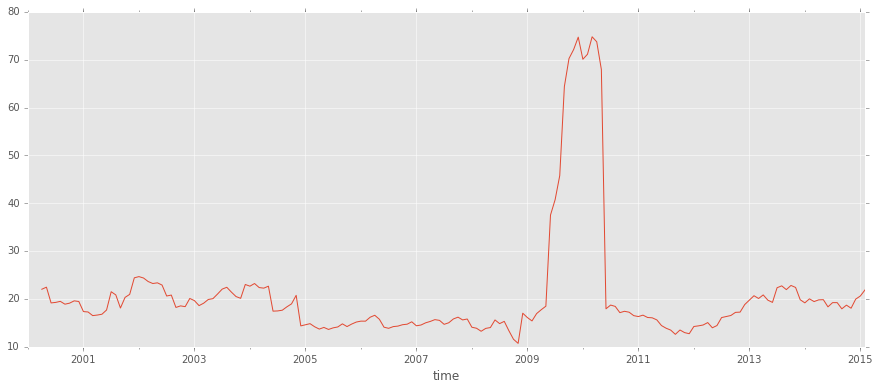

In [115]:
df_pe.pe_aus.loc['2000-01-01':].plot.line()

## Summary: 

#### There are basically 3 test we can run to test if a time series is stationary. ADF have low power when times series is close to random walk, PP test will do better in that aspect. We can also runn KPSS test to compare
#### Test results can be heavily affect by specification, so we need to make sure that we correctly specify the model by (in/ex)clude constant and trend 